In [1]:
# !pip install geopandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
# !pip install reverse_geocoder

     |████████████████████████████████| 2.2 MB 8.9 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268087 sha256=bacf8aa49470e20f6eea905091321fc522a920b9cf984d1ea38e8f74a9877b15
  Stored in directory: /home/jupyter/.cache/pip/wheels/34/6e/70/5423639428a2cac8ea7eb467214a4254b549b381f306a9c790
Successfully built reverse-geocoder


In [2]:
import seaborn as sns
import reverse_geocoder as rg

## Preprocessing

### First Dataset

In [3]:
%%bigquery df_perimeters
SELECT * FROM `data-401-326622.final_project.fires`

Downloading: 100%|██████████| 20772/20772 [00:22<00:00, 911.58rows/s] 


In [150]:
df_perimeters.STATE.value_counts()

CA    20683
NV       70
OR       15
AZ        1
Name: STATE, dtype: int64

In [4]:
df_perimeters_ca = df_perimeters[(df_perimeters.STATE=='CA')]
df_perimeters_ca.sample(n=5)

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Length,Shape_Area,geom
1418,29619,1972.0,CA,CDF,BTU,WEBB/COLE,00000000,1972-06-07 00:00:00+00:00,None,14.0,None,NaN,302.949432,NaN,1.0,00000076,5850.063392,1.225993e+06,"POLYGON((-121.556605305852 39.5399301737662, -..."
5773,22409,1915.0,CA,USF,LPF,,00000000,None,None,9.0,None,NaN,702.340332,NaN,1.0,0000090B,7380.633872,2.842270e+06,"POLYGON((-121.371095663614 35.9661207253067, -..."
18720,39989,1999.0,CA,NPS,KNP,WILLIAMS,00000000,1999-09-18 00:00:00+00:00,1999-12-29 00:00:00+00:00,1.0,None,573.0,573.867615,8.0,2.0,00000076,8822.339621,2.322360e+06,"POLYGON((-118.688100565325 36.7438899355262, -..."
3152,27264,1924.0,CA,USF,KNF,,00000000,None,None,14.0,None,NaN,1008.985046,NaN,1.0,00000134,9709.622117,4.083218e+06,"POLYGON((-121.952655694901 41.6835182951046, -..."
15158,40595,2013.0,CA,NPS,YNP,RICHARDSON,00000133,2013-09-21 00:00:00+00:00,2013-10-18 00:00:00+00:00,1.0,2013-CAYNP-0133 Managed Lightning Ignited,NaN,0.079067,1.0,1.0,None,64.166262,3.199725e+02,"POLYGON((-119.692137985726 38.0725007428949, -..."


In [5]:
df_2010s = df_perimeters_ca[df_perimeters_ca.YEAR_ >= 2010]

### Second dataset

In [7]:
%%bigquery df_env
SELECT * FROM `data-401-326622.final_project.terraclimate_with_fire_distance`

Downloading: 100%|██████████| 7338672/7338672 [00:04<00:00, 1532641.87rows/s]


In [16]:
# run this instead of above if you mess up somewhere

df_env_ = df_env.copy()
df_env_ = df_env_[(df_env_.tmax > 0) & (df_env_.tmin > 0)]

**Primary Climate Variables**: Maximum temperature, minimum temperature, vapor pressure, precipitation accumulation, downward surface shortwave radiation, wind-speed

**Derived variables**: Reference evapotranspiration (ASCE Penman-Montieth), Runoff, Actual Evapotranspiration, Climate Water Deficit, Soil Moisture, Snow Water Equivalent, Palmer Drought Severity Index, Vapor pressure deficit

In [17]:
df_env_.dropna(inplace=True)

In [18]:
loc_tuple = list(zip(df_env_.lat,df_env_.lon))

In [19]:
loc_arr = np.array(rg.search(loc_tuple))

In [20]:
df_env_["CA"] = pd.Series(map(lambda x: x['admin1'] == "California", loc_arr), index = df_env_.index)

In [21]:
df_env_ca = df_env_[df_env_.CA == True].drop('CA', axis=1)

In [14]:
df_env_ca

,lat,lon,month,year,aet,def,pet,ppt,q,soil,srad,swe,tmax,tmin,vap,ws,vpd,PDSI,fire_dist
1013,36.812500,-119.312500,12,2020,357,95,452,367,18,233,21071,0,1400,430,681,210,54,-402,20049.958599
1014,36.354168,-121.395836,12,2020,356,143,499,365,18,84,20614,0,1680,280,709,220,63,-308,173546.851474
1022,37.729168,-121.562500,1,2020,262,59,321,185,9,728,23674,0,1380,410,890,190,31,201,214002.098871
1023,37.687500,-119.770836,1,2020,417,44,461,395,20,1877,21318,0,1320,200,552,210,56,74,267201.437761
1026,36.854168,-117.812500,1,2020,24,618,642,25,1,0,17987,0,1590,140,529,280,72,-238,423854.050927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7338664,35.812500,-119.937500,10,2020,5,1265,1270,0,0,58,9869,0,3180,1390,1050,210,211,-159,37002.520239
7338665,34.520832,-117.187500,10,2020,2,1521,1523,1,0,11,8216,0,2910,1240,696,310,205,94,45369.299045
7338666,34.062500,-119.854164,10,2020,27,987,1014,7,0,196,11054,0,2420,1390,1276,270,104,-159,70041.787521
7338668,36.479168,-120.145836,11,2020,87,524,611,88,4,47,17185,0,1920,590,918,200,66,-279,87485.880434


## Visualizations

In [22]:
%%bigquery df_counties
SELECT state_fips_code, county_name, int_point_lat,int_point_lon,int_point_geom,county_geom
FROM `bigquery-public-data.geo_us_boundaries.counties`

Downloading: 100%|██████████| 3233/3233 [00:25<00:00, 126.23rows/s]


In [23]:
df_counties_ = df_counties.copy()

In [24]:
us_boundaries_ca = df_counties_[df_counties_.state_fips_code == "06"]

In [25]:
ca_counties_gdf = gpd.GeoDataFrame(us_boundaries_ca,
                                   geometry=gpd.GeoSeries.from_wkt(us_boundaries_ca.county_geom),
                                   crs='EPSG:4326')

In [26]:
fires_gdf_2010s = gpd.GeoDataFrame(df_2010s.geom,geometry=gpd.GeoSeries.from_wkt(df_2010s.geom),crs='EPSG:4326')
fires_gdf_2010s['Shape_Area'] = df_2010s['Shape_Area']

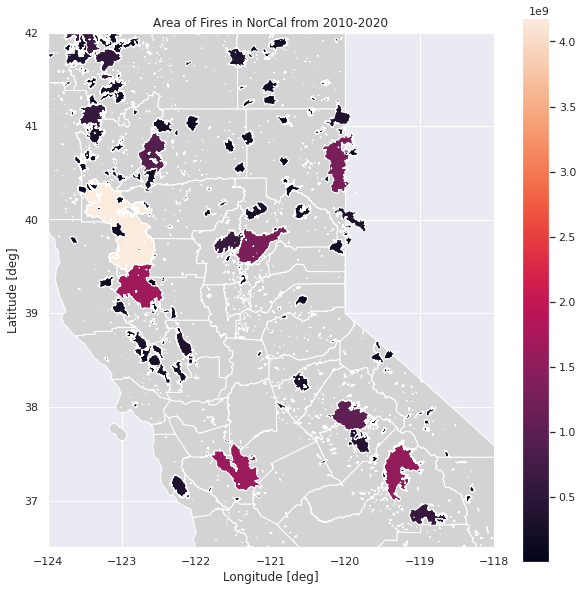

In [153]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set(xlim=(-124, -118), ylim=(36.5, 42))
ca_counties_gdf.plot(ax=ax, color="lightgray")
fires_gdf_2010s.plot(column="Shape_Area",legend=True,ax=ax)
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_title("Area of Fires in NorCal from 2010-2020")
fig.show()

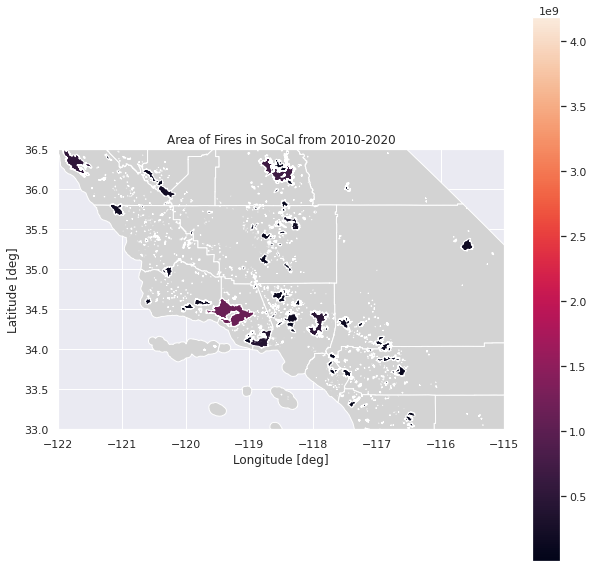

In [152]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set(xlim=(-122, -115), ylim=(33, 36.5))
ca_counties_gdf.plot(ax=ax, color="lightgray")
fires_gdf_2010s.plot(column="Shape_Area",legend=True,ax=ax)
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.set_title("Area of Fires in SoCal from 2010-2020")
fig.show()

[Text(0.5, 1.0, 'Distribution of Differences between Min and Max Fire Temperatures per Month')]

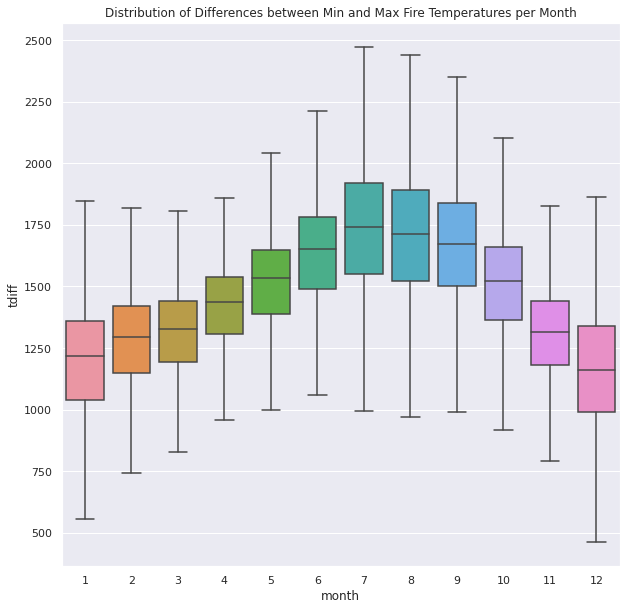

In [31]:
df_env_ca['tdiff'] = df_env_ca.tmax - df_env_ca.tmin
sns.set(rc={'figure.figsize':(10,10)})
sns.boxplot(x="month",y="tdiff",data=df_env_ca, showfliers=False).set(
    title="Distribution of Differences between Min and Max Fire Temperatures per Month"
    )

[Text(0.5, 1.0, 'Distribution of Soil Moisture Levels per Month')]

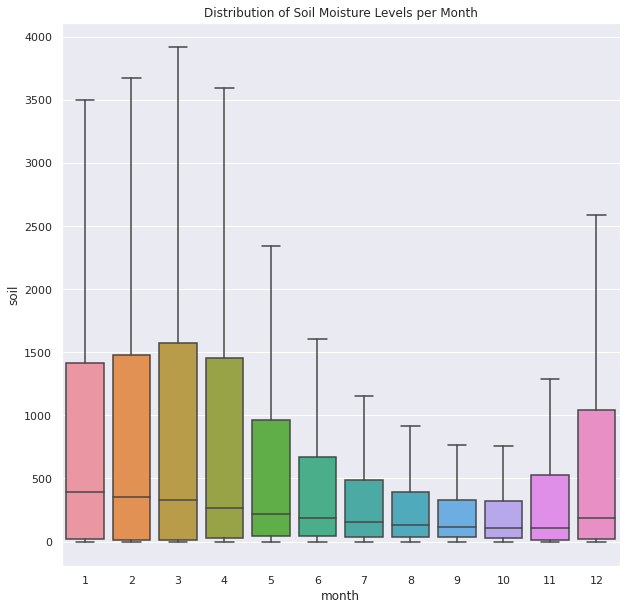

In [81]:
sns.set(rc={'figure.figsize':(10,10)})
sns.boxplot(x="month",y="soil",data=df_env_ca, showfliers=False).set(
    title="Distribution of Soil Moisture Levels per Month"
    )

In [114]:
df_env_ca.year.value_counts()

2020    241887
2015    241437
2017    238699
2018    238331
2012    237476
2019    231243
2016    228088
2014    227789
2013    223006
2010    221183
2011    210023
Name: year, dtype: int64

<AxesSubplot:xlabel='lon', ylabel='lat'>

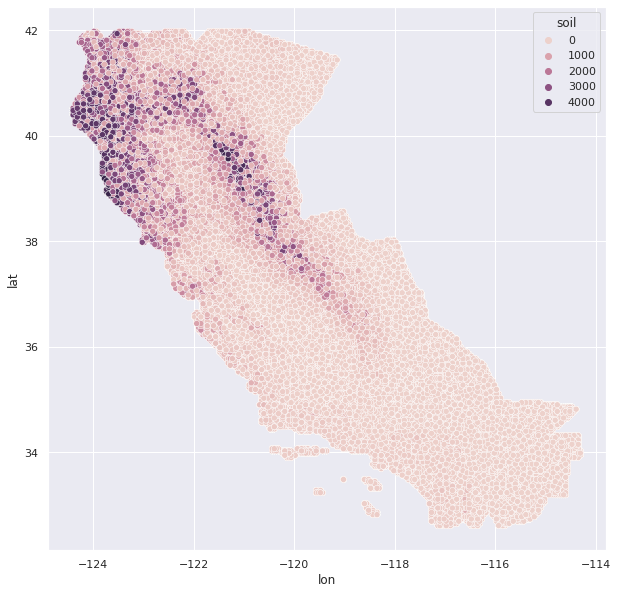

In [119]:
sns.set(rc={'figure.figsize':(10,10)})
sns.scatterplot(x="lon",y="lat",hue="soil",data=df_env_ca[df_env_ca.year == 2018])

## Modeling

In [104]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

In [39]:
# 7 miles is about 11,265 meters

df_env_ca["fire"] = (df_env_.fire_dist < 11265) * 1

In [40]:
df_env_ca.fire.value_counts()

0    2427710
1     111452
Name: fire, dtype: int64

In [119]:
zeros = df_env_ca[df_env_ca.fire == 0].sample(n = 60000)
ones = df_env_ca[df_env_ca.fire == 1].sample(n = 40000)

In [120]:
df_bal = pd.concat([zeros,ones])

In [121]:
X = df_bal.drop(['fire_dist',"fire","tdiff","year"], axis=1)
y = df_bal.fire

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 401)

### Logistic Regression

In [78]:
scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)

In [81]:
model = LogisticRegression(max_iter = 300)
model.fit(X_train_sc, y_train)

LogisticRegression(max_iter=300)

In [82]:
np.mean(cross_validate(model, X_train_sc, y_train,scoring = 'accuracy', cv = 10)['test_score'])

0.6885666666666668

In [83]:
list(zip(X_train.columns,model.coef_[0]))

[('lat', -2.0097708329435187),
 ('lon', -4.292996758517515),
 ('month', 2.7503083620016433),
 ('aet', -0.18837851164450128),
 ('def', 0.7808225852407696),
 ('pet', 0.6814632746307716),
 ('ppt', 1.836071411087064),
 ('q', -3.8689643984925204),
 ('soil', -0.8439336196010713),
 ('srad', -3.722091661918981),
 ('swe', 0.7387055771632064),
 ('tmax', 2.5201717042315863),
 ('tmin', 1.4878896944271867),
 ('vap', -3.8956376836346287),
 ('ws', -2.288874125563192),
 ('vpd', -5.123865781761878),
 ('PDSI', -0.5001899426285442)]

In [84]:
X_test_sc = scaler.fit_transform(X_test)

logit_preds = model.predict(X_test_sc)
accuracy_score(y_test, logit_preds), f1_score(y_test, logit_preds)

(0.6793333333333333, 0.6855181431840471)

#### Tuning ridge regularization attempt

In [85]:
from scipy.stats import loguniform
estimator_ridge = LogisticRegression(penalty = "l2",max_iter = 300)
parameters_rand = {'C':loguniform(.001,1)}
parameters_rand

{'C': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fd2101a8dd0>}

In [86]:
randomized_search_logit = RandomizedSearchCV(estimator_ridge,parameters_rand,verbose=1)
randomized_search_logit.fit(X_train_sc,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=LogisticRegression(max_iter=300),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd2101a8dd0>},
                   verbose=1)

In [87]:
randomized_search_logit.best_params_, randomized_search_logit.best_score_

({'C': 0.2570789263574544}, 0.688525)

### Random Forest

In [129]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

RandomForestClassifier()

In [135]:
model_rf2 = RandomForestClassifier(n_estimators=200, max_depth=40)
model_rf2.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, n_estimators=200)

In [130]:
np.mean(cross_validate(model_rf, X_train, y_train,scoring = 'accuracy', cv = 10)['test_score'])

0.8960750000000001

In [136]:
np.mean(cross_validate(model_rf2, X_train, y_train,scoring = 'accuracy', cv = 10)['test_score'])

0.8971250000000002

In [131]:
mfi_temp = list(model_rf.feature_importances_)
for i in range(len(mfi_temp)):
    print(mfi_temp[i], X_train.columns[i])

0.07717384608585814 lat
0.09321924838635436 lon
0.06692736088421054 month
0.046345980924326645 aet
0.05814397737977225 def
0.05501950749505504 pet
0.042619042986575824 ppt
0.022063266563837766 q
0.1229207857130667 soil
0.0691904926935335 srad
4.41331470627181e-05 swe
0.04928652236601341 tmax
0.05246859909278214 tmin
0.056919415208433514 vap
0.05155676776515837 ws
0.073062457479205 vpd
0.06303859582875398 PDSI


Latitude, longitude, month and soil moisture appear to be most important in predicting whether there is a wildfire, at least in California

#### Tuning attempts

In [132]:
# parameters = {'max_depth':[5,7,10,15,20]}
parameters = {'max_depth':[20, 25, 30, 40]}
estimator = RandomForestClassifier()

grid_search_rf = GridSearchCV(estimator,parameters,verbose=1)
grid_search_rf.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [20, 25, 30, 40]}, verbose=1)

In [60]:
grid_search_rf.best_params_, grid_search_rf.best_score_

({'max_depth': 40}, 0.9023200000000001)

In [133]:
grid_search_rf.cv_results_

{'mean_fit_time': array([18.2841207 , 19.4384429 , 19.7395184 , 19.83709159]),
 'std_fit_time': array([0.03870318, 0.06091566, 0.06656092, 0.05619796]),
 'mean_score_time': array([0.34331198, 0.37491632, 0.38921103, 0.39056096]),
 'std_score_time': array([0.00214849, 0.00099693, 0.00276533, 0.00116305]),
 'param_max_depth': masked_array(data=[20, 25, 30, 40],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 20},
  {'max_depth': 25},
  {'max_depth': 30},
  {'max_depth': 40}],
 'split0_test_score': array([0.874125, 0.88225 , 0.884375, 0.887   ]),
 'split1_test_score': array([0.8750625, 0.88525  , 0.889875 , 0.8895   ]),
 'split2_test_score': array([0.8779375, 0.888125 , 0.892625 , 0.89325  ]),
 'split3_test_score': array([0.8733125, 0.8843125, 0.8859375, 0.887    ]),
 'split4_test_score': array([0.8805625, 0.891375 , 0.8908125, 0.8935   ]),
 'mean_test_score': array([0.8762   , 0.8862625, 0.888725 , 0.89005  ])

In [134]:
parameters = {'n_estimators':[100, 150, 200]}

grid_search_rf = GridSearchCV(estimator,parameters,verbose=1)
grid_search_rf.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [100, 150, 200]}, verbose=1)

In [63]:
grid_search_rf.best_params_, grid_search_rf.best_score_

({'n_estimators': 200}, 0.90319)

### Support Vector Machine

SVM has usually taken the longest to run so I'm doing it on a smaller subset

In [92]:
model_svc= SVC()
model_svc.fit(X_train_sc[:10000,:],y_train[:10000])

SVC()

In [94]:
np.mean(cross_validate(model_svc, X_train.iloc[:10000,:], y_train[:10000],scoring = 'accuracy', cv = 10)['test_score'])

0.6629

Already not as promising as the RFC at smaller subsets

### Gradient Boosting

In [99]:
model_gb = GradientBoostingClassifier()
#model_gb.fit(X_train, y_train)

In [100]:
np.mean(cross_validate(model_gb, X_train, y_train,scoring = 'accuracy', cv = 10)['test_score'])

0.7808416666666667

## Final model and testing

Ultimately decided to use the random forest classifier at default settings, since the tuned parameters did not make a big difference.

In [106]:
from sklearn.metrics import confusion_matrix

In [138]:
rf_preds = model_rf.predict(X_test)
accuracy_score(y_test, rf_preds), f1_score(y_test, rf_preds)

(0.898, 0.8774185794976566)

In [140]:
conf = confusion_matrix(y_test, rf_preds)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  # This is added back by InteractiveShellApp.init_path()


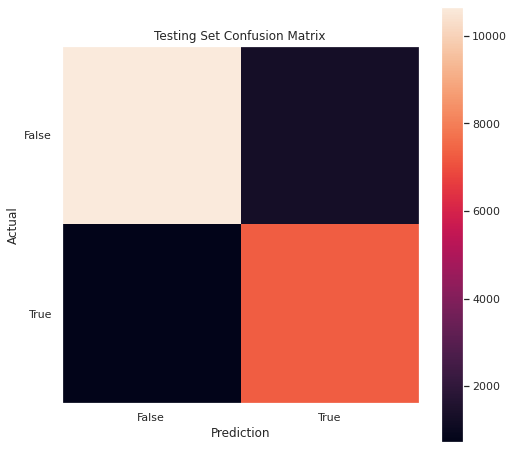

In [141]:
fig, ax = plt.subplots()
ax.set_title('Testing Set Confusion Matrix')
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['False', 'True'])
ax.set_yticks(np.arange(2))
ax.set_yticklabels(['False', 'True'])
ax.set_ylabel('Actual')
ax.set_xlabel('Prediction')
ax.grid(False)
cbar = ax.imshow(conf)
fig.colorbar(cbar, ax=ax)
fig.set_size_inches(8, 8)

### Testing on imbalanced dataset

In [142]:
df_imbal = df_env_ca.drop(index=df_bal.index)

In [143]:
X_imbal = df_imbal.drop(['fire_dist',"fire","tdiff","year"], axis=1)
y_imbal = df_imbal.fire

In [146]:
rf_preds_im = model_rf.predict(X_imbal)
accuracy_score(y_imbal, rf_preds_im), f1_score(y_imbal, rf_preds_im)

(0.8916193348371285, 0.3300506343228737)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  del sys.path[0]


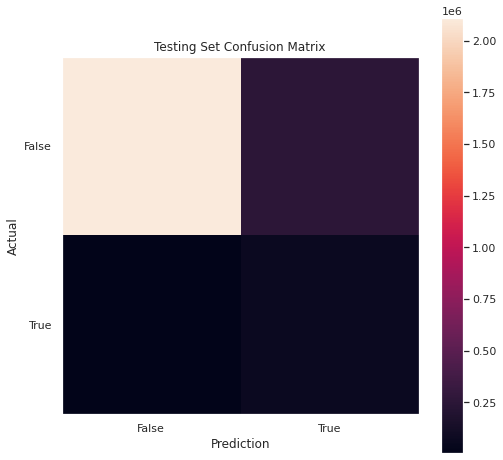

In [147]:
conf_im = confusion_matrix(y_imbal, rf_preds_im)

fig, ax = plt.subplots()
ax.set_title('Testing Set Confusion Matrix')
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['False', 'True'])
ax.set_yticks(np.arange(2))
ax.set_yticklabels(['False', 'True'])
ax.set_ylabel('Actual')
ax.set_xlabel('Prediction')
ax.grid(False)
cbar = ax.imshow(conf_im)
fig.colorbar(cbar, ax=ax)
fig.set_size_inches(8, 8)